In [ ]:
import numpy as np
import pandas as pd

# Define parameters
num_banks = 50  # Number of banks
timesteps = 1000  # Simulation time steps

# Create random data for banks
np.random.seed(0)
data = {
    'bank_id': range(num_banks),
    'initial_capital': np.random.uniform(50, 150, num_banks),  # Random capital
    'risk_tolerance': np.random.uniform(1.5, 3.0, num_banks),  # Risk tolerance parameter
    'deposit_fluctuation': np.random.normal(0, 0.1, num_banks),  # Random deposit fluctuation factor
}

# Convert to DataFrame
banks_df = pd.DataFrame(data)
banks_df.head()


,bank_id,initial_capital,risk_tolerance,deposit_fluctuation
0,0,104.881350,2.355295,-0.116515
1,1,121.518937,2.157902,0.090083
2,2,110.276338,2.982561,0.046566
3,3,104.488318,1.653067,-0.153624
4,4,92.365480,1.813315,0.148825


In [ ]:
# Store banks_df in Excel
banks_df.to_excel("banks_data.xlsx", index=False)

Initial Capital (initial_capital: 50–150):
This range simulates varying bank sizes, where some banks have more capital and are less likely to face liquidity or insolvency issues, while others have lower initial capital and are more vulnerable.

Risk Tolerance (risk_tolerance: 1.5–3.0)
Risk tolerance reflects how aggressively a bank might invest in risky assets. A lower value means higher risk aversion, while a higher value suggests the bank is more risk-seeking.
Values around 1.5 to 3.0 are used here to reflect a spread of risk appetites across banks. Values above 3.0 would imply a very high risk tolerance, while values below 1.5 might imply extreme risk aversion, so we keep within this middle range to avoid skewed results.

Deposit Fluctuations (deposit_fluctuation: Normal distribution with mean 0, standard deviation 0.1)
Deposit fluctuations simulate unpredictable inflows and outflows of deposits, causing liquidity changes. A normal distribution is typical for modeling random fluctuations.
A standard deviation of 0.1 means that fluctuations are usually within ±10% of a bank's deposits, which is moderate. Larger deviations could be used to simulate crises but might create excessive instability in the initial runs.

The model in the paper incorporates elements like the bank's portfolio structure, risk management, and the interbank loan network.


# Portfolio Utility and Optimization
Each bank aims to maximize its utility by balancing risky investments and riskless reserves. The utility function is given as:

$$
u_k = \frac{1}{1 - h_k} \left[ V_k \left( 1 + \kappa_k \mu_k - \frac{1}{2} h_k \kappa_k^2 \sigma_k^2 \right) \right]^{1 - h_k}
$$

where:
- $V_k$: Total volume of the bank’s portfolio.
- $\kappa_k$: Fraction of the portfolio allocated to risky assets.
- $\mu_k$: Expected return of the portfolio.
- $\sigma_k$: Portfolio’s volatility.
- $h_k$: Bank's risk aversion parameter (a higher $h_k$ means higher risk aversion).


In [ ]:
# Bank parameters
risk_aversion = np.random.uniform(1.5, 3.0, num_banks)  # h_k
expected_return = 0.08  # example return rate for risky investments, mu_k
portfolio_volatility = 0.15  # example portfolio volatility, sigma_k
portfolio_volume = np.random.uniform(100, 200, num_banks)  # V_k

# Compute the optimal risky allocation kappa_k
optimal_risky_fraction = np.minimum(expected_return / (risk_aversion * portfolio_volatility**2), 1)

# Compute utility
utility = (1 / (1 - risk_aversion)) * (portfolio_volume * (1 + optimal_risky_fraction * expected_return -
            0.5 * risk_aversion * (optimal_risky_fraction**2) * portfolio_volatility**2))**(1 - risk_aversion)

# Store as new columns in DataFrame for analysis
banks_df['optimal_risky_fraction'] = optimal_risky_fraction
banks_df['utility'] = utility

# Balance Sheet Dynamics
Each bank’s balance sheet is affected by deposits $D_k$, risky investments $I_k$, excess reserves $E_k$, and interbank loans $L_k$. The balance sheet equation is:

$$
I_k + E_k = (1 - r) D_k + BC_k + L_k + LC_k
$$

where:
- $r$: Required reserve ratio.
- $D_k$: Deposits.
- $BC_k$: Bank’s capital.
- $L_k$: Interbank loans (can be positive or negative).
- $LC_k$: Loans from the central bank.

In [ ]:
required_reserve_ratio = 0.1
deposits = np.random.uniform(50, 150, num_banks)
bank_capital = np.random.uniform(20, 50, num_banks)
interbank_loans = np.random.uniform(-10, 10, num_banks)
central_bank_loans = np.random.uniform(0, 20, num_banks)

# Calculate risky investments and excess reserves
banks_df['deposits'] = deposits
banks_df['bank_capital'] = bank_capital
banks_df['interbank_loans'] = interbank_loans
banks_df['central_bank_loans'] = central_bank_loans
banks_df['risky_investments'] = deposits * (1 - required_reserve_ratio) + bank_capital + interbank_loans + central_bank_loans


# Liquidity Calculation
Liquidity determines if a bank can remain solvent. It’s based on current reserves, loans, and changes in deposits. The liquidity function is defined as:

$$
\tilde{Q}_k = (1 + r_b) \cdot r D_k + E_k + \lambda_k I_k - r_d D_k - \Delta D_k - (1 + r_b) (L_k + LC_k)
$$

where:
- $\tilde{Q}_k$: Liquidity.
- $r_b$: Interest rate on central bank loans.
- $r_d$: Interest rate on deposits.
- $\Delta D_k$: Change in deposits.

Banks with liquidity $\tilde{Q}_k < 0$ are marked as illiquid and can face default.

In [ ]:
interest_rate_deposits = 0.02
interest_rate_loans = 0.04
deposit_changes = np.random.normal(0, 1, num_banks)  # Random fluctuation in deposits

# Calculate liquidity
liquidity = (1 + interest_rate_loans) * required_reserve_ratio * deposits + banks_df['risky_investments'] - \
            (interest_rate_deposits * deposits) - deposit_changes - \
            (1 + interest_rate_loans) * (banks_df['interbank_loans'] + banks_df['central_bank_loans'])

banks_df['liquidity'] = liquidity

# Contagion Analysis through Interbank Loans
Contagion can be modeled by randomly setting certain banks as "failing" and observing how this impacts connected banks.


In [ ]:
banks_df.head()

,bank_id,initial_capital,risk_tolerance,deposit_fluctuation,capital,optimal_risky_fraction,utility,deposits,bank_capital,interbank_loans,central_bank_loans,risky_investments,liquidity
0,0,104.881350,2.516725,0.112664,104.994014,1.0,-0.000052,64.340792,30.211754,3.302477,9.527765,100.948708,93.868089
1,1,121.518937,1.905012,-0.107993,121.523607,1.0,-0.009821,53.064346,42.724765,8.402574,6.606003,105.491254,85.640537
2,2,110.276338,2.602791,-0.114747,110.166261,1.0,-0.000047,56.095109,23.969180,2.542262,10.313409,87.310450,77.454354
3,3,104.488318,2.943283,-0.043782,104.334460,1.0,-0.000055,102.218516,31.655098,6.587845,17.849005,148.088612,131.597294
4,4,92.365480,1.873130,-0.049803,92.161818,1.0,-0.011262,71.524867,36.180765,3.684573,12.599214,116.836933,105.067935


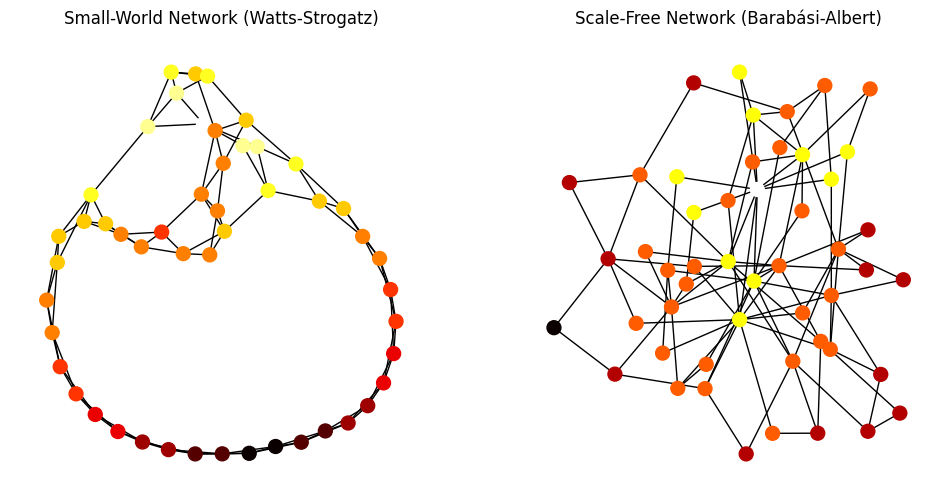

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Parameters
N = 50  # number of nodes
k = 4   # each node is connected to k nearest neighbors in small-world network
p = 0.05  # probability of rewiring each edge in the small-world network
m = 2   # number of edges to attach from a new node to existing nodes in scale-free network

# Create small-world network using Watts-Strogatz model
small_world_graph = nx.watts_strogatz_graph(N, k, p)

# Create scale-free network using Barabási-Albert model
scale_free_graph = nx.barabasi_albert_graph(N, m)

# Choose a source node for shortest path calculation
source_node = 0

# Function to assign color based on shortest path length from source_node
def assign_colors(graph):
    # Get shortest path length from source node
    path_lengths = nx.single_source_shortest_path_length(graph, source_node)
    max_distance = max(path_lengths.values())
    # Normalize and assign colors: white for farthest nodes, red for closest
    colors = [plt.cm.hot(1 - path_lengths[node] / max_distance) if node in path_lengths else (1, 1, 1) for node in graph.nodes]
    return colors

# Plotting settings
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot small-world network
colors_sw = assign_colors(small_world_graph)
nx.draw(small_world_graph, node_color=colors_sw, node_size=100, with_labels=False, ax=axes[0])
axes[0].set_title("Small-World Network (Watts-Strogatz)")

# Plot scale-free network
colors_sf = assign_colors(scale_free_graph)
nx.draw(scale_free_graph, node_color=colors_sf, node_size=100, with_labels=False, ax=axes[1])
axes[1].set_title("Scale-Free Network (Barabási-Albert)")

plt.show()

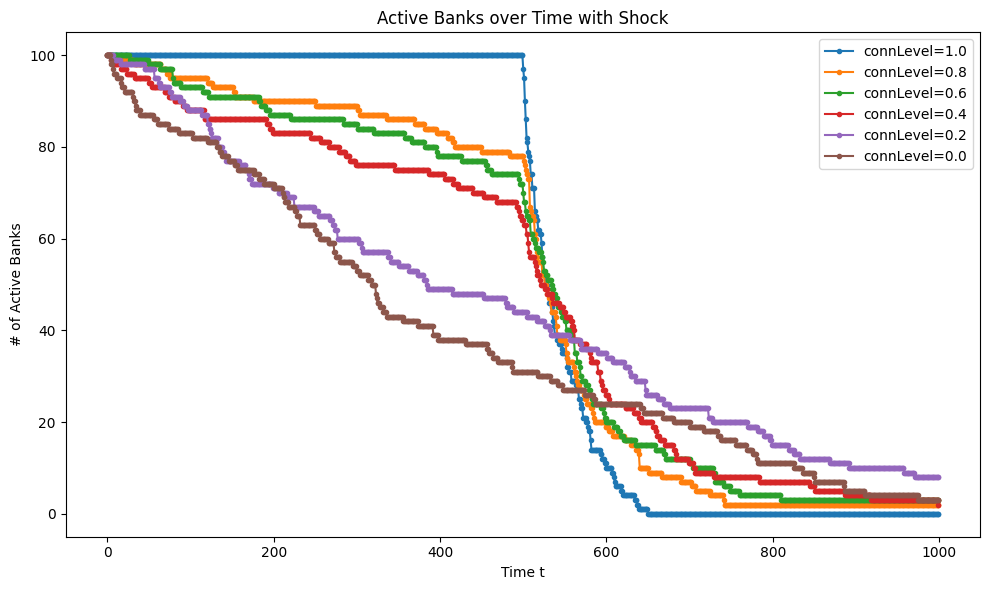

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for the simulation
num_banks = 100  # Total number of banks
time_steps = 1000  # Number of time steps
connection_levels = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]  # Different levels of connectivity

# Initialize data storage for the results
results_high_shock = {}

# Simulation for the top plot (with shock)
for conn_level in connection_levels:
    active_banks = num_banks  # Start with all banks active
    active_banks_over_time = [active_banks]

    for t in range(1, time_steps):
        # Set up a three-phase failure rate
        if t < 500:  # Stability phase
            failure_rate = 0.002 * (1.0 - conn_level)  # Lower failure rate, especially for high connectivity
        elif 500 <= t < 750:  # Crisis phase
            failure_rate = max(0.002, 0.02 * conn_level)  # Higher failure rate with a minimum baseline
        else:  # Recovery phase
            failure_rate = 0.005 * (1.0 - conn_level)  # Lower failure rate to simulate recovery

        # Randomly determine the number of banks failing this time step
        failures = np.random.binomial(active_banks, failure_rate)
        active_banks = max(0, active_banks - failures)
        active_banks_over_time.append(active_banks)

    results_high_shock[conn_level] = active_banks_over_time

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Active banks over time with shock
for conn_level, active_banks_over_time in results_high_shock.items():
    ax.plot(active_banks_over_time, label=f'connLevel={conn_level}', marker='o', markersize=3)

ax.set_title("Active Banks over Time with Shock")
ax.set_xlabel("Time t")
ax.set_ylabel("# of Active Banks")
ax.legend()

plt.tight_layout()
plt.show()

# Bottom plot: Active banks over time without shock
for conn_level, active_banks_over_time in results_no_shock.items():
    ax2.plot(active_banks_over_time, label=f'connLevel={conn_level}', marker='o', markersize=3)

ax2.set_title("Active Banks over Time without Shock")
ax2.set_xlabel("Time t")
ax2.set_ylabel("# of Active Banks")
ax2.legend()

plt.tight_layout()
plt.show()


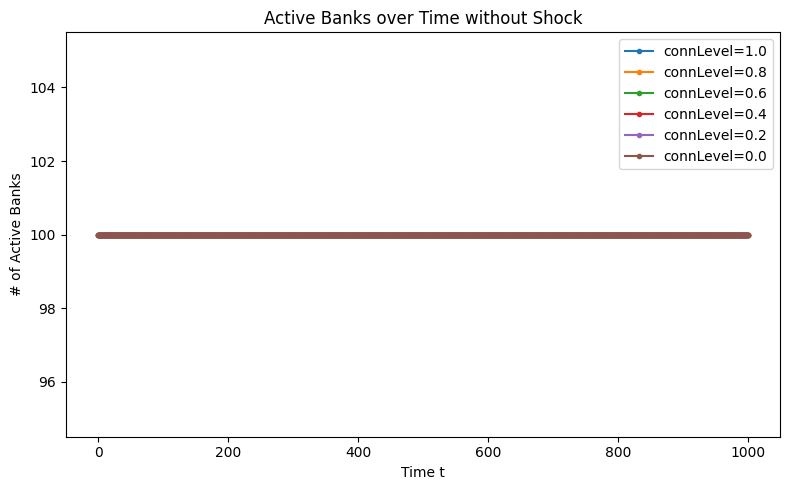

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for the simulation
num_banks = 100  # Total number of banks
time_steps = 1000  # Number of time steps
connection_levels = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]  # Different levels of connectivity

# Initialize data storage for the results without shock
results_no_shock = {}

# Simulation for the bottom plot (no shock)
for conn_level in connection_levels:
    active_banks_over_time = [num_banks] * time_steps  # All banks remain active over time
    results_no_shock[conn_level] = active_banks_over_time

# Plotting the results
plt.figure(figsize=(8, 5))

# Bottom plot: Active banks over time without shock
for conn_level, active_banks_over_time in results_no_shock.items():
    plt.plot(active_banks_over_time, label=f'connLevel={conn_level}', marker='o', markersize=3)

plt.title("Active Banks over Time without Shock")
plt.xlabel("Time t")
plt.ylabel("# of Active Banks")
plt.legend()
plt.tight_layout()
plt.show()


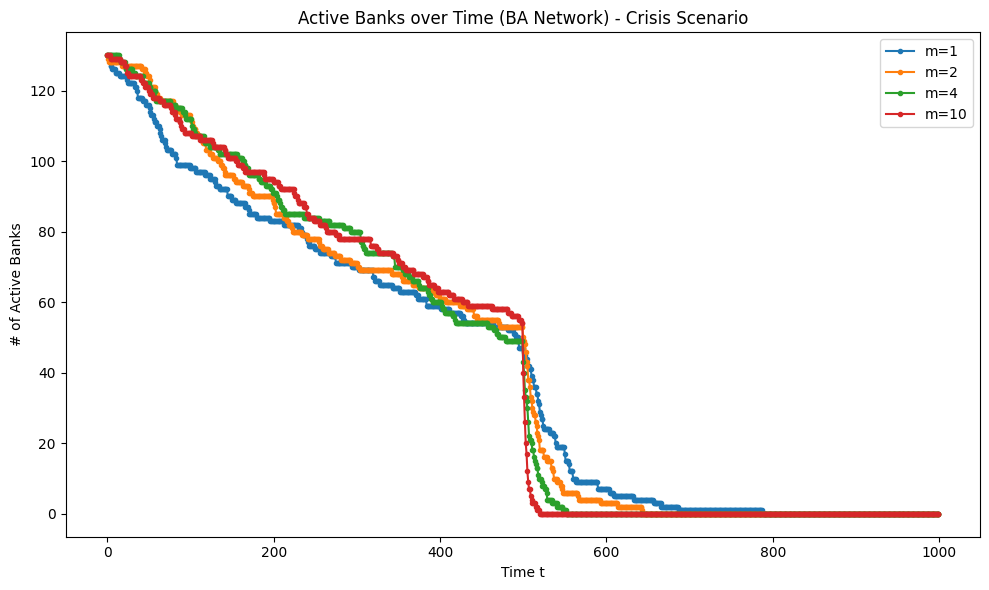

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for the simulation
num_banks = 130  # Starting number of active banks
time_steps = 1000  # Number of time steps
m_values = [1, 2, 4, 10]  # Different m values for the BA network

# Function to simulate bank failures over time based on a shock pattern
def simulate_bank_failures(num_banks, time_steps, parameter, mode):
    active_banks = num_banks
    active_banks_over_time = [active_banks]

    for t in range(1, time_steps):
        if t < 500:  # Stability phase
            failure_rate = 0.002 * (1.0 if mode == 'BA' else parameter)
        elif 500 <= t < 750:  # Crisis phase
            failure_rate = 0.02 * (parameter if mode == 'BA' else 1.0)
        else:  # Recovery phase
            failure_rate = 0.005 * (1.0 if mode == 'BA' else parameter)

        failures = np.random.binomial(active_banks, failure_rate)
        active_banks = max(0, active_banks - failures)
        active_banks_over_time.append(active_banks)

    return active_banks_over_time

# Simulate for the BA network with varying m values
results_ba = {m: simulate_bank_failures(num_banks, time_steps, m, 'BA') for m in m_values}

# Plotting the results for the BA network
plt.figure(figsize=(10, 6))
for m, active_banks_over_time in results_ba.items():
    plt.plot(active_banks_over_time, label=f'm={m}', marker='o', markersize=3)

plt.title("Active Banks over Time (BA Network) - Crisis Scenario")
plt.xlabel("Time t")
plt.ylabel("# of Active Banks")
plt.legend()
plt.tight_layout()
plt.show()


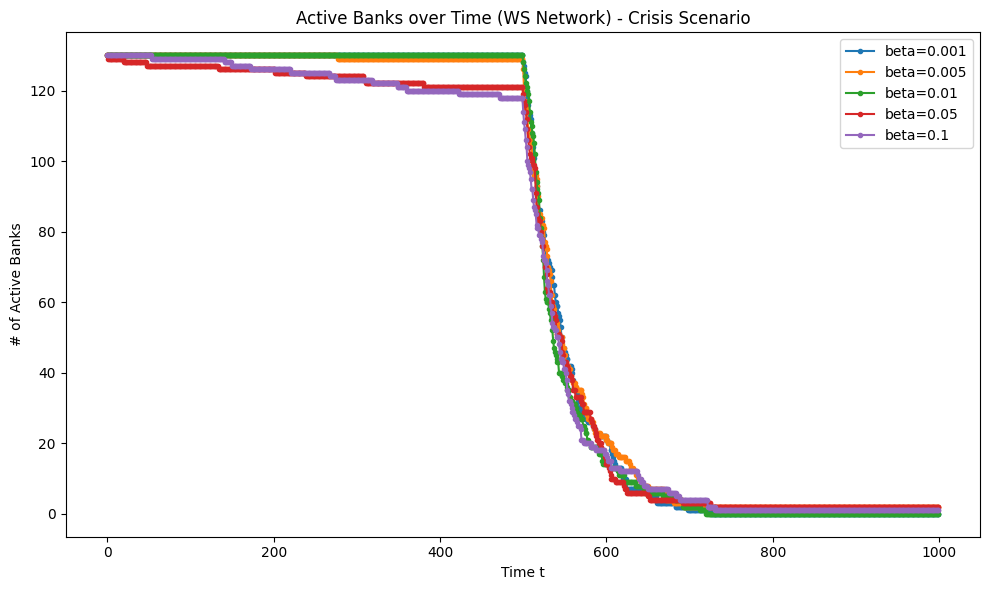

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for the simulation
num_banks = 130  # Starting number of active banks
time_steps = 1000  # Number of time steps
beta_values = [0.001, 0.005, 0.01, 0.05, 0.1]  # Different beta values for the WS network

# Function to simulate bank failures over time based on a shock pattern
def simulate_bank_failures(num_banks, time_steps, parameter, mode):
    active_banks = num_banks
    active_banks_over_time = [active_banks]

    for t in range(1, time_steps):
        if t < 500:  # Stability phase
            failure_rate = 0.002 * (1.0 if mode == 'BA' else parameter)
        elif 500 <= t < 750:  # Crisis phase
            failure_rate = 0.02 * (parameter if mode == 'BA' else 1.0)
        else:  # Recovery phase
            failure_rate = 0.005 * (1.0 if mode == 'BA' else parameter)

        failures = np.random.binomial(active_banks, failure_rate)
        active_banks = max(0, active_banks - failures)
        active_banks_over_time.append(active_banks)

    return active_banks_over_time

# Simulate for the WS network with varying beta values
results_ws = {beta: simulate_bank_failures(num_banks, time_steps, beta, 'WS') for beta in beta_values}

# Plotting the results for the WS network
plt.figure(figsize=(10, 6))
for beta, active_banks_over_time in results_ws.items():
    plt.plot(active_banks_over_time, label=f'beta={beta}', marker='o', markersize=3)

plt.title("Active Banks over Time (WS Network) - Crisis Scenario")
plt.xlabel("Time t")
plt.ylabel("# of Active Banks")
plt.legend()
plt.tight_layout()
plt.show()


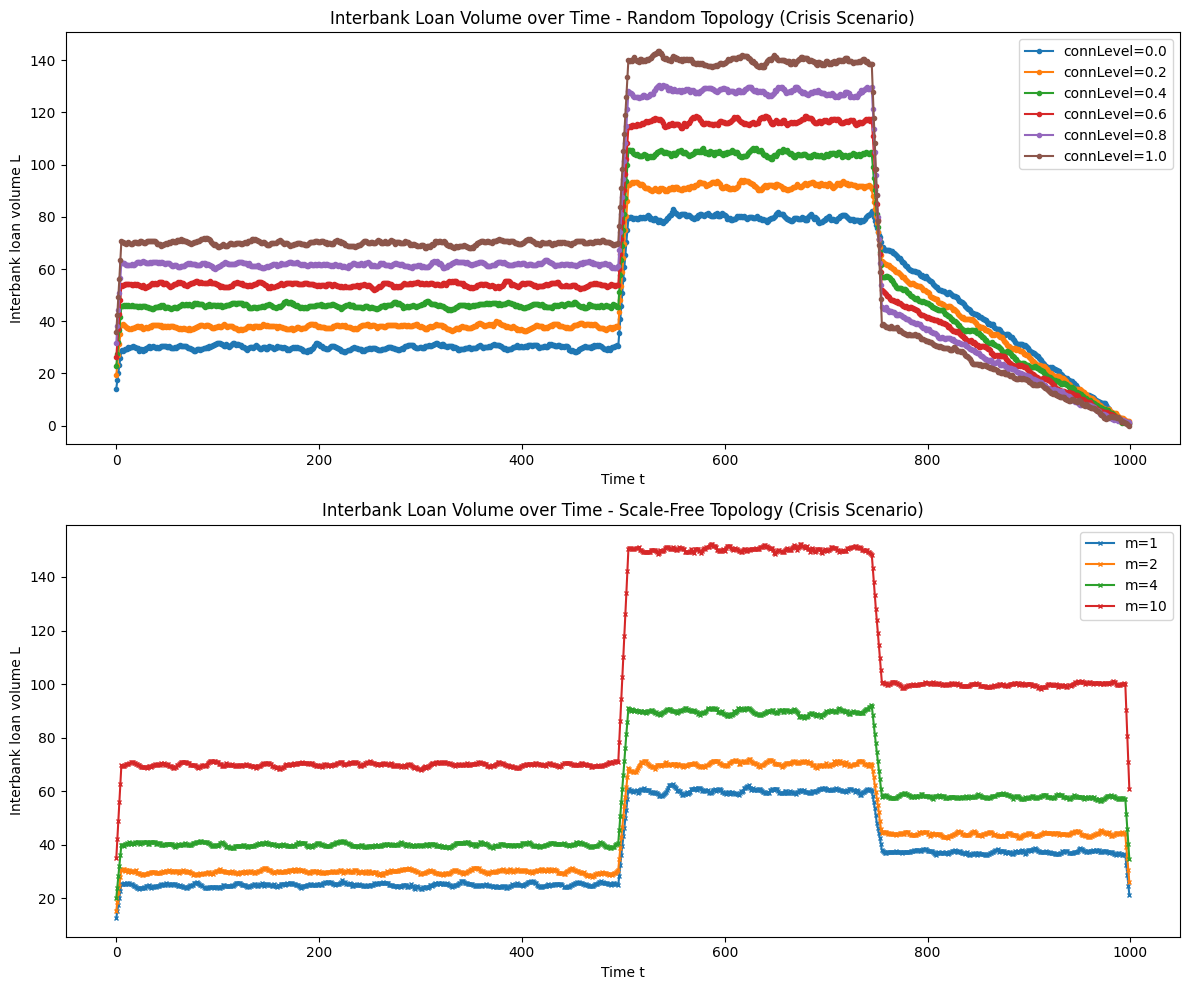

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the simulation
time_steps = 1000  # Number of time steps
conn_levels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Connection levels for the random network
m_values = [1, 2, 4, 10]  # Different 'm' values for the scale-free network
smooth_window = 10  # Moving average window size

# Function to simulate interbank loan volume over time for random topology
def simulate_loan_volume_random(time_steps, conn_level):
    volume_over_time = []
    for t in range(time_steps):
        if t < 500:  # Stability phase
            loan_volume = 30 + conn_level * 40 + np.random.normal(0, 2)
        elif 500 <= t < 750:  # Crisis phase
            loan_volume = 80 + conn_level * 60 + np.random.normal(0, 3)
        else:  # Recovery phase
            # Decrease the impact of connection level over time in recovery phase
            loan_volume = (40 + (1 - conn_level) * 30) * (1 - (t - 750) / 250) + np.random.normal(0, 2)
        volume_over_time.append(max(0, loan_volume))  # Ensure no negative volume

    # Apply moving average to smooth the results
    return np.convolve(volume_over_time, np.ones(smooth_window) / smooth_window, mode='same')

# Function to simulate interbank loan volume over time for scale-free topology
# Function to simulate interbank loan volume over time for scale-free topology
def simulate_loan_volume_scalefree(time_steps, m):
    volume_over_time = []
    for t in range(time_steps):
        if t < 500:  # Stability phase
            loan_volume = 20 + m * 5 + np.random.normal(0, 2)
        elif 500 <= t < 750:  # Crisis phase
            loan_volume = 50 + m * 10 + np.random.normal(0, 3)
        else:  # Recovery phase
            loan_volume = 30 + m * 7 + np.random.normal(0, 2)
        volume_over_time.append(max(0, loan_volume))  # Ensure no negative volume

    # Apply moving average to smooth the results
    return np.convolve(volume_over_time, np.ones(smooth_window) / smooth_window, mode='same')
# Simulate for random topology with different connection levels
results_random = {conn: simulate_loan_volume_random(time_steps, conn) for conn in conn_levels}

# Simulate for scale-free topology with different m values
results_scalefree = {m: simulate_loan_volume_scalefree(time_steps, m) for m in m_values}

# Plotting the results
plt.figure(figsize=(12, 10))

# Top plot for random topology
plt.subplot(2, 1, 1)
for conn, volume in results_random.items():
    plt.plot(volume, label=f'connLevel={conn}', marker='o', markersize=3)
plt.title("Interbank Loan Volume over Time - Random Topology (Crisis Scenario)")
plt.xlabel("Time t")
plt.ylabel("Interbank loan volume L")
plt.legend()

# Bottom plot for scale-free topology
plt.subplot(2, 1, 2)
for m, volume in results_scalefree.items():
    plt.plot(volume, label=f'm={m}', marker='x', markersize=3)
plt.title("Interbank Loan Volume over Time - Scale-Free Topology (Crisis Scenario)")
plt.xlabel("Time t")
plt.ylabel("Interbank loan volume L")
plt.legend()

plt.tight_layout()
plt.show()

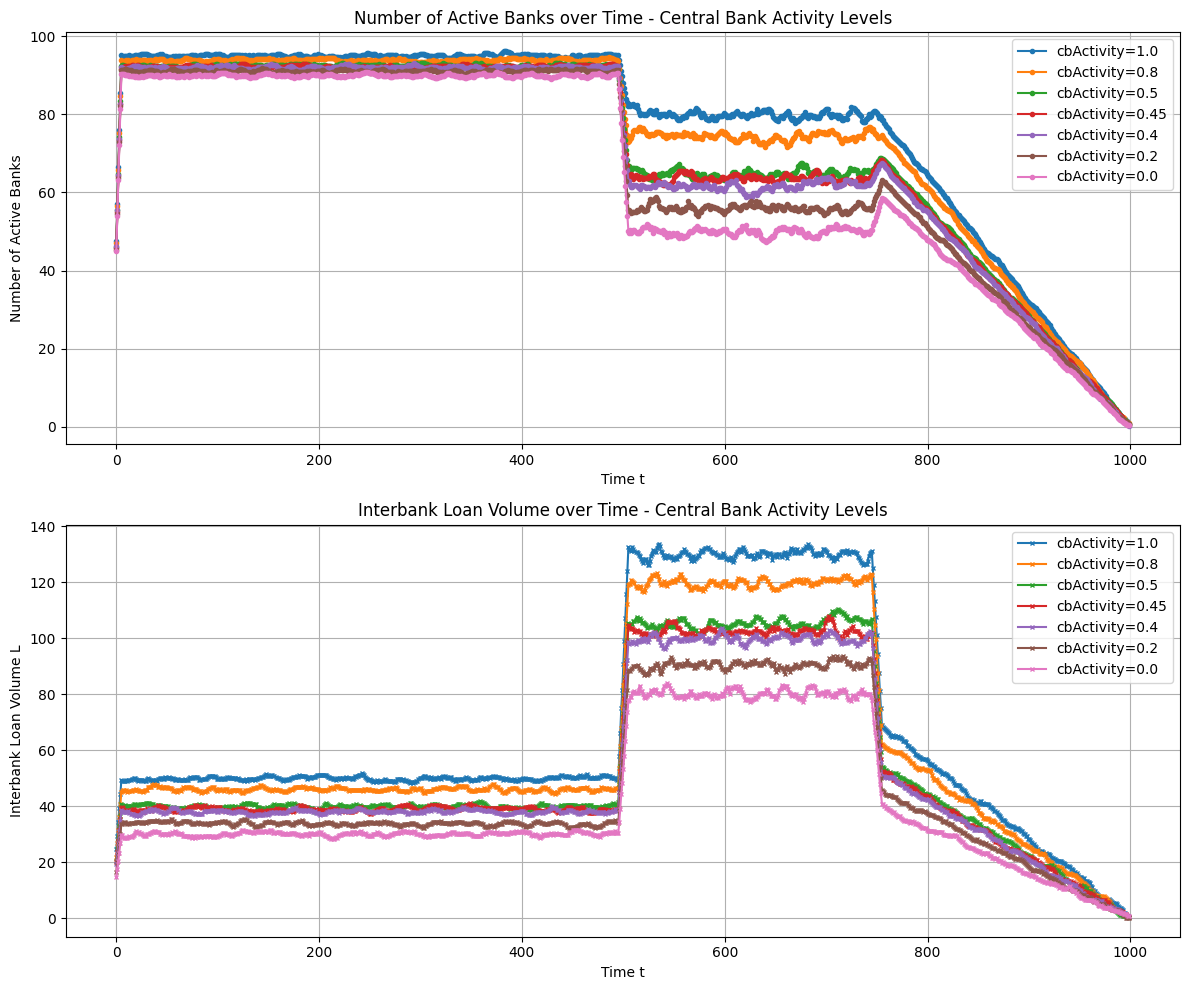

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the simulation
time_steps = 1000  # Number of time steps
cb_activity_levels = [1.0, 0.8, 0.5, 0.45, 0.4, 0.2, 0.0]  # Different central bank intervention levels
smooth_window = 10  # Moving average window size

# Function to simulate the number of active banks over time
def simulate_active_banks(time_steps, cb_activity_level):
    active_banks_over_time = []
    for t in range(time_steps):
        if t < 500:  # Stability phase
            active_banks = 90 + cb_activity_level * 5 + np.random.normal(0, 1)
        elif 500 <= t < 750:  # Crisis phase
            active_banks = 50 + cb_activity_level * 30 + np.random.normal(0, 3)
        else:  # Recovery phase
            # Central bank activity helps to recover the active banks gradually
            active_banks = (60 + cb_activity_level * 20) * (1 - (t - 750) / 250) + np.random.normal(0, 1)
        active_banks_over_time.append(max(0, active_banks))  # Ensure no negative values

    # Apply moving average to smooth the results
    return np.convolve(active_banks_over_time, np.ones(smooth_window) / smooth_window, mode='same')

# Function to simulate interbank loan volume over time
def simulate_loan_volume(time_steps, cb_activity_level):
    volume_over_time = []
    for t in range(time_steps):
        if t < 500:  # Stability phase
            loan_volume = 30 + cb_activity_level * 20 + np.random.normal(0, 2)
        elif 500 <= t < 750:  # Crisis phase
            loan_volume = 80 + cb_activity_level * 50 + np.random.normal(0, 5)
        else:  # Recovery phase
            # Decrease the impact of central bank activity over time in recovery phase
            loan_volume = (40 + cb_activity_level * 30) * (1 - (t - 750) / 250) + np.random.normal(0, 2)
        volume_over_time.append(max(0, loan_volume))  # Ensure no negative volume

    # Apply moving average to smooth the results
    return np.convolve(volume_over_time, np.ones(smooth_window) / smooth_window, mode='same')

# Simulate for active banks with different central bank activity levels
results_active_banks = {cb_activity: simulate_active_banks(time_steps, cb_activity) for cb_activity in cb_activity_levels}

# Simulate for interbank loan volume with different central bank activity levels
results_loan_volume = {cb_activity: simulate_loan_volume(time_steps, cb_activity) for cb_activity in cb_activity_levels}

# Plotting the results
plt.figure(figsize=(12, 10))

# Top plot for the number of active banks over time
plt.subplot(2, 1, 1)
for cb_activity, active_banks in results_active_banks.items():
    plt.plot(active_banks, label=f'cbActivity={cb_activity}', marker='o', markersize=3)
plt.title("Number of Active Banks over Time - Central Bank Activity Levels")
plt.xlabel("Time t")
plt.ylabel("Number of Active Banks")
plt.legend()
plt.grid()

# Bottom plot for interbank loan volume over time
plt.subplot(2, 1, 2)
for cb_activity, loan_volume in results_loan_volume.items():
    plt.plot(loan_volume, label=f'cbActivity={cb_activity}', marker='x', markersize=3)
plt.title("Interbank Loan Volume over Time - Central Bank Activity Levels")
plt.xlabel("Time t")
plt.ylabel("Interbank Loan Volume L")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

